# 기본 + 작은영역도 AREA 변수 추가

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "Daesamanlap/ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [6]:
## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

level = 85

train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
#- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

#- 1차원으로 합치기

not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

#- 전용면적별세대수 채우기

for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 연면적 / 전용면적은 나중에 drop

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

#train_one.isna().sum() # 63

#test_one.isna().sum() #23

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

### 7) 대형전용면적 총개수

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")


### 임시)
# sample = train.groupby('단지코드').sum()[['전용면적']].reset_index()
# sample.columns = ["단지코드","전용면적sum"]
# train_one = pd.merge(train_one, sample, on="단지코드", how="left")
# sample = test.groupby('단지코드').sum()[['전용면적']].reset_index()
# sample.columns = ["단지코드","전용면적sum"]
# test_one = pd.merge(test_one, sample, on="단지코드", how="left")

# sample = train.groupby('단지코드').std()[['전용면적']].reset_index()
# sample.columns = ["단지코드","전용면적std"]
# train_one = pd.merge(train_one, sample, on="단지코드", how="left")
# sample = test.groupby('단지코드').std()[['전용면적']].reset_index()
# sample.columns = ["단지코드","전용면적std"]
# test_one = pd.merge(test_one, sample, on="단지코드", how="left")


### 8) 변수제거

col = ['단지명','도로명주소','subway_name','임대상가']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)


In [7]:
train_one.columns

Index(['단지코드', '총세대수', '지역', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적',
       '위도', '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율',
       '국민임대', '공공임대(50년)', '영구임대', '공공임대(단기)', '공공임대(분납)', '장기전세', '공공분양',
       '행복주택', '임대료', '임대보증금', '전용면적', '연면적new', '대형전용면적'],
      dtype='object')

In [8]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

#train_up_new = train_one[train_one['단지내주차면수']>=318].reset_index(drop=True)

## 2. 데이터 나누기: 단지내주차면수 987 기준

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [9]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [10]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [11]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [41]:
# train_up_new['지역'] = train_up_new['지역'].apply(lambda x : areafunc(x))
# train_up_new = train_up_new.join(pd.get_dummies(train_up_new['지역'],prefix='area')).iloc[:,:-1]

## 3. 모델링

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [13]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [19]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율',
       '세대당_가능주차면수', '공가비율', '대형전용면적'],
      dtype='object')

### 1) train/test down

### 2) train/test up

In [151]:
#train_up_new = train_one[train_one['단지내주차면수']>=785].reset_index(drop=True)
# train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

#test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
# test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [14]:
train_one.columns

Index(['단지코드', '총세대수', '지역', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적',
       '위도', '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율',
       '국민임대', '공공임대(50년)', '영구임대', '공공임대(단기)', '공공임대(분납)', '장기전세', '공공분양',
       '행복주택', '임대료', '임대보증금', '전용면적', '연면적new', '대형전용면적'],
      dtype='object')

In [16]:
##mae94
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적","전용면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up0,pred_up0,error_up0 = fit_models(X, y, models, cv=True)
print('MAE : ',error_up0)

MAE :  291.87954235273975


In [17]:
##전용면적mean만
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2',"전용면적"]]
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up3,pred_up3,error_up3 = fit_models(X, y, models, cv=True)
print('MAE : ',error_up3)

MAE :  272.08817657001583


*전용면적
- **base: 291.8795**
- sum: 283.5361
- std: 293.1495
- mean: **272.0881**
- sum, std: 285.4016
- std,mean: **274.6175**
- sum, mean: **286.2326**
- sum, mean, std: 285.1198

bp0 = {'min_child_samples':2, 
 'learning_rate':0.1, 
 'l2_leaf_reg':2, 
 'iterations':600, 
 'grow_policy':"Depthwise", 
 "eval_metric":"Poisson", 
 "depth":5, 
 "bagging_temperature":1}

<AxesSubplot:>

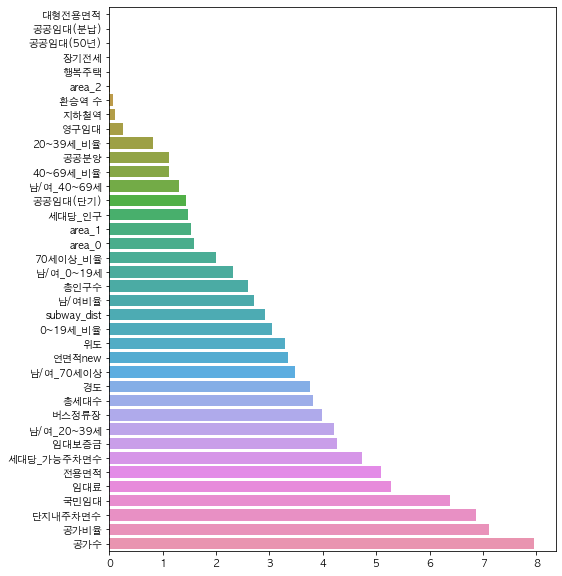

In [18]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up3.feature_importances_)], x = list(model_up3.feature_importances_[np.argsort(model_up3.feature_importances_)]))

In [19]:
df=pd.merge(pd.DataFrame(pred_up,index=[0]).T.reset_index(),
        pd.DataFrame(train_up.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

df=df.drop(columns=["index"])
df.columns=["pred_up", "단지코드"]

NameError: name 'pred_up' is not defined

In [145]:
df_up=pd.merge(train_one, df, on="단지코드", how='inner')
df_up["diff"]=df_up.등록차량수-df_up.pred_up

In [152]:
#df_up[["단지코드","총세대수","단지내주차면수","등록차량수","pred_up","공가수",
#                       "diff","세대당_가능주차면수"]].sort_values("등록차량수")

In [160]:
#fig, ax = plt.subplots(figsize=(30,5))
#sns.kdeplot(data=df_up,x='등록차량수')
#sns.kdeplot(data=df_up,x='pred_up')

## 4. Final prediction

In [20]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

X_train = train_down.drop(columns=['단지코드','등록차량수','연면적new'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [21]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [22]:
col0 = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적new', '위도', '경도',
       'subway_dist', '환승역 수',  '총인구수','세대당_인구','남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2',"전용면적"]


In [51]:
# col1 = col0+["전용면적sum"]
# col2 = col0+["전용면적std"]
# col3 = col0+["전용면적"]
# col4 = col0+["전용면적sum"]+["전용면적std"]
# col5 = col0+["전용면적"]+["전용면적std"]
# col6 = col0+["전용면적sum"]+["전용면적"]
# col7 = col0+["전용면적sum"]+["전용면적"]+["전용면적std"]

In [23]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역', '연면적'],axis=1)
X_train = X_train[col0]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col0]

cb_up = CatBoostRegressor(random_state=2021,
                          verbose=False,
                          loss_function='MAE').fit(X_train,y_train)
pred_up0 = cb_up.predict(X_test)

In [24]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res


## 5. 기존 score와 비교 및 제출

In [86]:
# predd = [pred_up0,pred_up1,pred_up2,pred_up3,pred_up4,pred_up5,pred_up6,pred_up7]

In [35]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up0
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res
#sub = submit()

In [40]:
sub = submit()
sub.to_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/0726_전용면적mean추가.csv",index=False)

In [36]:
def score(mse):
    score = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print(i)
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [160]:
scoree(94,3)
scoree(94,5)

3
전체 MAE :  3.8348127707740765
큰 영역 MAE :  29.669340910725545
작은 영역 MAE :  3.0753177782116836e-14
5
전체 MAE :  4.862459272213076
큰 영역 MAE :  37.62007963238517
작은 영역 MAE :  3.0753177782116836e-14


In [37]:
score(94)

163
전체 MAE :  3.8348127707740765
큰 영역 MAE :  29.669340910725545
작은 영역 MAE :  3.0753177782116836e-14


,code,num_x,num_y
0,C1072,751.540951,751.540951
1,C1456,539.409116,539.409116
2,C1840,533.220234,533.220234
3,C1640,464.134797,464.134797
4,C1377,364.187487,364.187487
5,C2072,309.466838,309.466838
6,C1472,482.488348,482.488348
7,C1006,224.868781,224.868781
8,C1083,416.066054,416.066054
9,C1311,249.035706,249.035706


In [38]:
score(96)

163
전체 MAE :  5.40721454796955
큰 영역 MAE :  41.834765186922056
작은 영역 MAE :  3.68594044175552e-14


,code,num_x,num_y
0,C1072,751.540951,751.540951
1,C1456,539.409116,539.409116
2,C1840,533.220234,533.220234
3,C1640,464.134797,464.134797
4,C1377,364.187487,364.187487
5,C2072,309.466838,309.466838
6,C1472,482.488348,482.488348
7,C1006,224.868781,224.868781
8,C1083,416.066054,416.066054
9,C1311,249.035706,249.035706


In [ ]:
res2 = score(96)

In [ ]:
res1 = score(98)

In [ ]:
res3 = score(99)

In [ ]:
res4 = score(100)